Notebook to explore different encodings for categorical features. EDA saw that we had some rare labels so will try grouping rare labels too. 

In [1]:
import sys
sys.path.append('../')

import src.utils.eda as eda
import src.utils.helper as helper
import src.train as train

from sklearn import set_config
set_config(transform_output = "pandas")

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from feature_engine import encoding as ce

In [2]:
data, discrete, temporal, continuous, categorical = helper.load_base_data()
data.head()

Discrete: ['Latitude', 'Longitude', 'Altitude']
Temporal: ['month', 'hour']
Continuous: ['Humidity', 'AmbientTemp', 'Wind.Speed', 'Visibility', 'Pressure', 'Cloud.Ceiling']
Categorical: ['Location', 'Season']


,Location,Latitude,Longitude,Altitude,Season,Humidity,AmbientTemp,Wind.Speed,Visibility,Pressure,Cloud.Ceiling,PolyPwr,month,hour
0,Camp Murray,47.11,-122.57,25.480965,Winter,81.71997,12.86919,8.053964,16.096495,1010.6,22.028990,2.42769,12,11
1,Camp Murray,47.11,-122.57,25.480965,Winter,96.64917,9.66415,0.000000,16.096495,1011.3,0.701755,2.46273,12,13
2,Camp Murray,47.11,-122.57,25.480965,Winter,93.61572,15.44983,8.053964,16.096495,1011.6,0.976354,4.46836,12,13
3,Camp Murray,47.11,-122.57,25.480965,Winter,77.21558,10.36659,8.053964,3.219299,1024.4,0.183066,1.65364,12,12
4,Camp Murray,47.11,-122.57,25.480965,Winter,54.80347,16.85471,4.832378,4.828948,1023.7,0.274600,6.57939,12,14


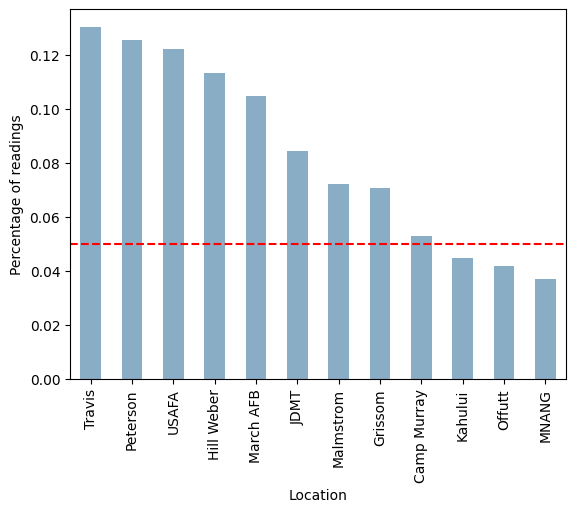

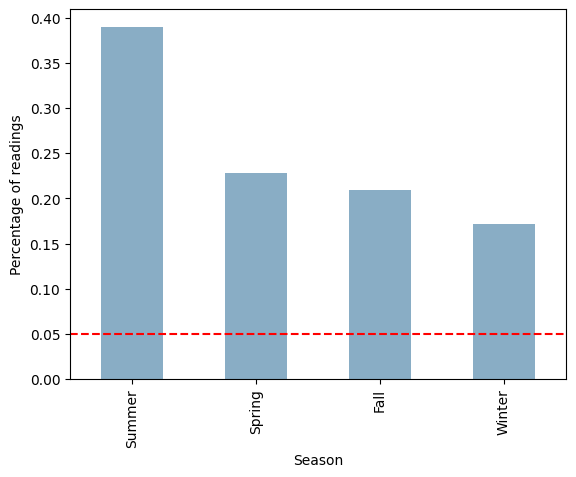

In [27]:
# Check for rare labels.
for col in ('Location', 'Season'):
    eda.plot_percentages_by_label(data, col)

In [3]:
X = data[discrete + temporal + continuous + categorical].copy()
y = data['PolyPwr'].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X,  # predictors
    y,  # target
    train_size=0.8,  # percentage of obs in train set
    random_state=0)  # seed to ensure reproducibility

print(X_train.shape, X_test.shape)
print(X.columns)


(16836, 13) (4209, 13)
Index(['Latitude', 'Longitude', 'Altitude', 'month', 'hour', 'Humidity',
       'AmbientTemp', 'Wind.Speed', 'Visibility', 'Pressure', 'Cloud.Ceiling',
       'Location', 'Season'],
      dtype='object')


In [26]:
pipeline = Pipeline([
    
    # CATEGORICAL
    # Group rare categories
    ('rare_label_encoder', 
     ce.RareLabelEncoder(tol=0.05,
                         n_categories=7,
                         variables=['Location'])),
    
    # # Label encode
    ('categorical_encoder',
     ce.OrdinalEncoder(encoding_method='ordered',
                       variables=['Season'])),
    
    ('categorical_encoder_loc',
     ce.OrdinalEncoder(encoding_method='arbitrary',
                       variables=['Location'])),
    
    # Model
    ('xgb', train.build_model())

])

scores = train.train_model(inputs=X_train, target=y_train, pipeline=pipeline)

CV Average R2: 0.6577604355815085


### Summary
After experimenting with combinations of arbitrary, ordered and mean encoding, and grouping rare labels in the Location feature, we ended up with an increase in the baseline to an R2 of about 0.657 with the following pipeline.

In [28]:
pipeline

Pipeline(steps=[('rare_label_encoder',
                 RareLabelEncoder(n_categories=7, variables=['Location'])),
                ('categorical_encoder', OrdinalEncoder(variables=['Season'])),
                ('categorical_encoder_loc',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Location'])),
                ('xgb',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_by...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=200, n_jobs=None,
                              num_parallel_tree=None, random_state=0, ...))])